# Load Dataset

In [1]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [2]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx.
num_section = 11

dat = alldat[num_section]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


In [3]:
print(len(alldat))

39


## Combine all sections of data

In [ ]:
# for i in range(len(alldat)):
#     if i<5:
#     # if i == 0:
#     #     spks_all = alldat[i]['spks']
#     # else:
#     #     spks_new = alldat[i]['spks']
#     #     spks_all = np.vstack((spks_all, spks_new))
#         print('spks',alldat[i]['spks'].shape)
#         # print('response',alldat[i]['response'].shape)
#         print('---------------------------')

In [ ]:
# print(spks_all.shape)

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the following fields:

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: exact position of the wheel that the mice uses to make a response, binned at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position. 
* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at `10ms`.
* `dat['brain_area_lfp']`: brain area names for the LFP channels. 
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['waveform_w']`: temporal components of spike waveforms. `w@u` reconstructs the time by channels action potential shape. 
* `dat['waveform_u]`: spatial components of spike waveforms.
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `lfp`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 




In [4]:
for i in range(len(alldat)):
  print(i, alldat[i]['mouse_name'])

0 Cori
1 Cori
2 Cori
3 Forssmann
4 Forssmann
5 Forssmann
6 Forssmann
7 Hench
8 Hench
9 Hench
10 Hench
11 Lederberg
12 Lederberg
13 Lederberg
14 Lederberg
15 Lederberg
16 Lederberg
17 Lederberg
18 Moniz
19 Moniz
20 Moniz
21 Muller
22 Muller
23 Muller
24 Radnitz
25 Radnitz
26 Radnitz
27 Radnitz
28 Radnitz
29 Richards
30 Richards
31 Richards
32 Richards
33 Richards
34 Tatum
35 Tatum
36 Tatum
37 Tatum
38 Theiler


# Plot Helper

In [5]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams 

rcParams['figure.figsize'] = [21, 9]

list_region = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
xaxis = range(len(list_region))
d = 20
w = 50

# Data Pre-process & Model Fitting --- neuron as feature
Since data shape is different in different sessions, loop all dataset for each session.

For each session, we loop through each brain region in the session and get the corresponding neurons and their spikes. Say for a certain brain region in a certain session, we have 'm_neuron', totally 'n_trial' trials and 'n_time' time bins (which is always 250), then transpose the shape of spikes from [m_neuron, n_trial, n_time] to [n_time, n_trial, m_neuron], along the 'n_time' dimension, the data then becomes to shape [n_trial, m_neuron], where we can treat the neurons as features and trials as samples. For each time bin, do the regression and get corresponding score, then get the average score along the time bins, which can be seen as the "score for this brain region".

***************************** SECTION 0 ||Mouse: Cori *****************************
(40, 214, 734)
(5, 214, 734)
0 [0 2 3 5 7]
=============== Region 0 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.6219626168224298
--------------------------------
spks_frag_stim---stim_contr (R)
0.6434579439252337
--------------------------------
spks_frag_response---response_move
0.6757009345794392
--------------------------------
spks_frag_response---response_LR
0.6514285714285715
--------------------------------
=============== Region 2 hipp ===============
spks_frag_stim---stim_ipsi (L)
0.719392523364486
--------------------------------
spks_frag_stim---stim_contr (R)
0.6538551401869158
--------------------------------
spks_frag_response---response_move
0.6971962616822429
--------------------------------
spks_frag_response---response_LR
0.6171428571428571
--------------------------------
=============== Region 3 other ctx ===============
spks_frag_stim---stim_ipsi (L)
0.7075934579439253


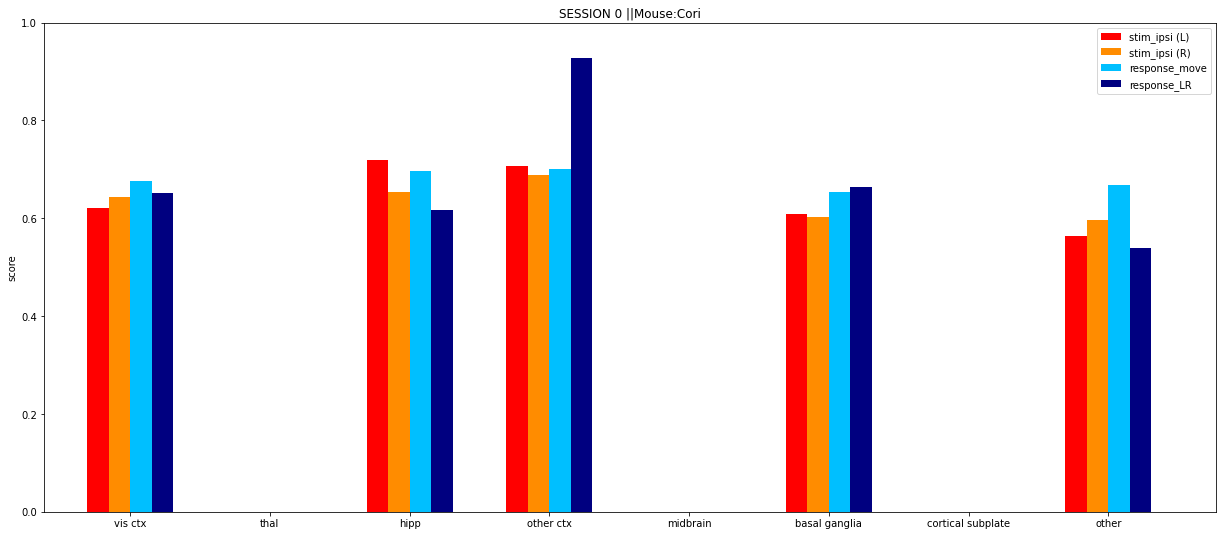

***************************** SECTION 1 ||Mouse: Cori *****************************
(40, 251, 1070)
(5, 251, 1070)
1 [0 2 7]
=============== Region 0 vis ctx ===============
spks_frag_stim---stim_ipsi (L)
0.7232071713147411
--------------------------------
spks_frag_stim---stim_contr (R)
0.8188247011952191
--------------------------------
spks_frag_response---response_move
0.80398406374502
--------------------------------
spks_frag_response---response_LR
0.7528662420382165
--------------------------------
=============== Region 2 hipp ===============
spks_frag_stim---stim_ipsi (L)
0.6889442231075698
--------------------------------


KeyboardInterrupt: ignored

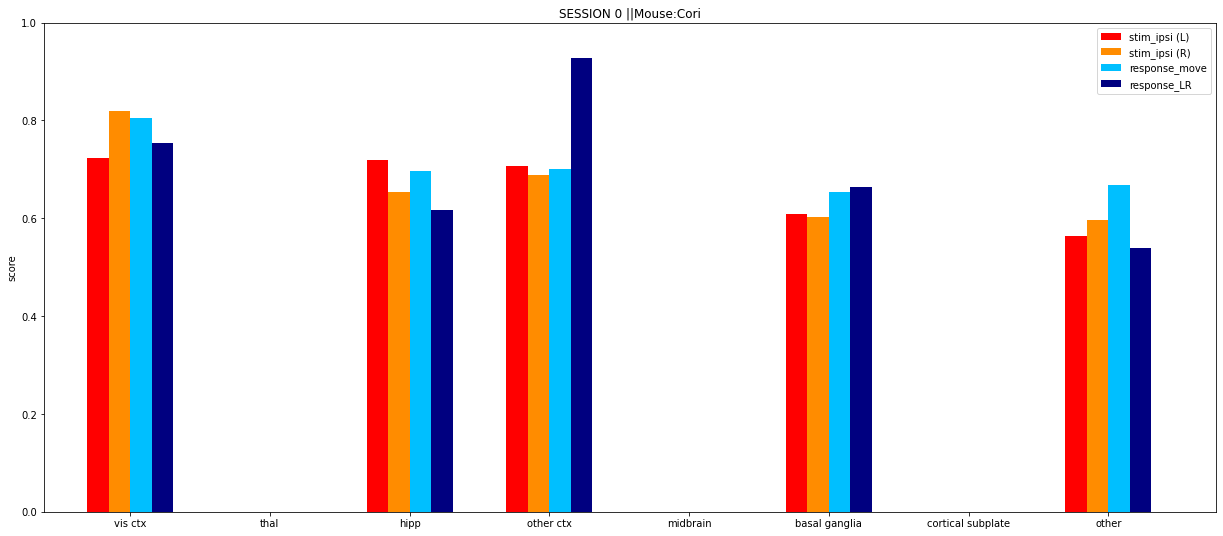

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

np.random.seed(31415)

# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

for i in range(len(alldat)):
    dat = alldat[i]
    #============================================ Data Pre-process ============================================
    print('***************************** SECTION', i, '||Mouse:', dat['mouse_name'], '*****************************')

    # for debug
    # if i!=11:
    # if i>2:
    #     continue

    # ************* Data for visual stimulus and response *************
    response = dat['response'] # right - nogo - left (-1, 0, 1) [n_trial,]
    response_move = np.where(response!=0, 1, 0)  # 1 as have response, 0 as not

    vis_right = dat['contrast_right'] # 0 - low - high [n_trial,]
    vis_left = dat['contrast_left'] # 0 - low - high [n_trial,]
    vis_diff = vis_left - vis_right

    stim_ipsi = np.where(vis_left!=0, 1, 0)  # ipsilateral stimulus [n_trial,]
    stim_contr = np.where(vis_right!=0, 1, 0)  # contralateral stilumus [n_trial,]


    # ************* Data for spike fragments related with stimulus *************
    spks = dat['spks'].transpose((2,1,0))  # [n_time, n_trial, n_neuron] (250, 340, 698)
    # print(spks.shape)
    n_time, n_trial, n_neuron = spks.shape[0], spks.shape[1], spks.shape[2]

    idx_spks_stim_start = 44  # idx of starting visual stimulus
    idx_spks_stim_end = 84
    spks_frag_stim = spks[idx_spks_stim_start:idx_spks_stim_end, ...]  # fragment of spikes related with stimulus
    print(spks_frag_stim.shape)


    # ************* Data for spike fragments related with response *************
    response_time = dat['response_time']  # [n_trial,1] (340,1)
    idx_response_time = np.round(response_time.squeeze()/0.01).astype(int)  # [n_trial,] (340,)


    # fragment of spikes related with response (5, 340, 698)
    num_pre = 5  # num of time bin pre the response to collect spks
    for idx_trial in range(n_trial):  # using loop, should have a better way...
        if idx_trial==0:
            # spks_frag_response = spks[idx_response_time[idx_trial]-num_pre:idx_response_time[idx_trial], idx_trial, :]
            # spks_frag_response = spks_frag_response[:,np.newaxis,:]
            if idx_response_time[idx_trial]>n_time:  # response time may bigger than time bin
                spks_frag_response = spks[-num_pre:, idx_trial, :]
                spks_frag_response = spks_frag_response[:,np.newaxis,:]
                # spks_frag_response = None
                # continue
            else:
                spks_frag_response = spks[idx_response_time[idx_trial]-num_pre:idx_response_time[idx_trial], idx_trial, :]
                spks_frag_response = spks_frag_response[:,np.newaxis,:]
        else:
            # spks_frag_new = spks[idx_response_time[idx_trial]-num_pre:idx_response_time[idx_trial], idx_trial, :]
            # spks_frag_new = spks_frag_new[:,np.newaxis,:]
            # spks_frag_response = np.concatenate((spks_frag_response, spks_frag_new), axis=1)
            if idx_response_time[idx_trial]>n_time:  # response time may bigger than time bin
                spks_frag_new = spks[-num_pre:, idx_trial, :]
                spks_frag_new = spks_frag_new[:,np.newaxis,:]
                # continue
            else:
                spks_frag_new = spks[idx_response_time[idx_trial]-num_pre:idx_response_time[idx_trial], idx_trial, :]
                spks_frag_new = spks_frag_new[:,np.newaxis,:]
            spks_frag_response = np.concatenate((spks_frag_response, spks_frag_new), axis=1)
    print(spks_frag_response.shape)


    # ************* Data for spks in different brain regions *************
    brain_area = dat['brain_area']
    list_brain_region = len(brain_area)*[len(regions)]

    for idx_neuron in range(len(brain_area)):
        for idx_brain_group in range(len(brain_groups)):
            if np.isin(brain_area[idx_neuron], brain_groups[idx_brain_group]):
                list_brain_region[idx_neuron] = idx_brain_group
                break
            else:
                list_brain_region[idx_neuron] = len(brain_groups)
    unique_list_brain_region = np.unique(list_brain_region)
    print(i, unique_list_brain_region)

    # loop through all brain groups
    for idx_brain_region in range(len(unique_list_brain_region)):
        num_region = unique_list_brain_region[idx_brain_region]  # the number of brain region now
        print('=============== Region', num_region, regions[num_region], '===============')
        idx_neuron_region = np.argwhere(list_brain_region==num_region).squeeze()
        spks_frag_stim_region = spks_frag_stim[...,idx_neuron_region]
        spks_frag_response_region = spks_frag_response[...,idx_neuron_region]

        #============================================ Model Fitting ============================================
        # ************* Logistic reg for spks_frag_stim---stim_ipsi (L) *************
        time_stim = spks_frag_stim_region.shape[0]
        # list_score_stimL_train = []
        # list_score_stimL_test = []
        list_score_stimL_all = []
        for idx_time in range(time_stim):
            X_stimL = spks_frag_stim_region[idx_time]  # [n_trial, m_ueuron]
            y_stimL = stim_ipsi  # [n_trial,]

            # X_stimL_train, X_stimL_test, y_stimL_train, y_stimL_test = train_test_split(X_stimL, y_stimL, test_size=0.2)
            # log_reg_l1L = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000).fit(X_stimL_train, y_stimL_train)
            # log_reg_l1L_all = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000).fit(X_stimL, y_stimL)
            log_reg_l1L_all = LogisticRegressionCV(penalty="l1", cv=5, solver="saga", max_iter=10000).fit(X_stimL, y_stimL)

            # score_trainL = log_reg_l1L.score(X_stimL_train, y_stimL_train)
            # score_testL = log_reg_l1L.score(X_stimL_test, y_stimL_test)
            score_allL = log_reg_l1L_all.score(X_stimL, y_stimL)
            # list_score_stimL_train.append(score_trainL)
            # list_score_stimL_test.append(score_testL)
            list_score_stimL_all.append(score_allL)
        print('spks_frag_stim---stim_ipsi (L)')
        # print(list_score_stimL_train)
        # print(np.sum(list_score_stimL_train)/len(list_score_stimL_train))
        # print(np.sum(list_score_stimL_test)/len(list_score_stimL_test))
        print(np.sum(list_score_stimL_all)/len(list_score_stimL_all))
        print('--------------------------------')
        # plot
        rects1 = plt.bar(x=(num_region)*(4*d+w), height=np.sum(list_score_stimL_all)/len(list_score_stimL_all),
                         width=d, color='red')


        # ************* Logistic reg for spks_frag_stim---stim_contr (R) *************
        time_stim = spks_frag_stim_region.shape[0]
        # list_score_stimR_train = []
        # list_score_stimR_test = []
        list_score_stimR_all = []
        for idx_time in range(time_stim):
            X_stimR = spks_frag_stim_region[idx_time]  # [n_trial, m_ueuron]
            y_stimR = stim_contr  # [n_trial,]

            # X_stimR_train, X_stimR_test, y_stimR_train, y_stimR_test = train_test_split(X_stimR, y_stimR, test_size=0.2)
            # log_reg_l1R = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000).fit(X_stimR_train, y_stimR_train)
            log_reg_l1R_all = LogisticRegressionCV(penalty="l1", cv=5, solver="saga", max_iter=10000).fit(X_stimR, y_stimR)

            # score_trainR = log_reg_l1R.score(X_stimR_train, y_stimR_train)
            # score_testR = log_reg_l1R.score(X_stimR_test, y_stimR_test)
            score_allR = log_reg_l1R_all.score(X_stimR, y_stimR)
            # list_score_stimR_train.append(score_trainR)
            # list_score_stimR_test.append(score_testR)
            list_score_stimR_all.append(score_allR)

        print('spks_frag_stim---stim_contr (R)')
        # print(np.sum(list_score_stimR_train)/len(list_score_stimR_train))
        # print(np.sum(list_score_stimR_test)/len(list_score_stimR_test))
        print(np.sum(list_score_stimR_all)/len(list_score_stimR_all))
        print('--------------------------------')
        # plot
        rects2 = plt.bar(x=(num_region)*(4*d+w)+d, height=np.sum(list_score_stimR_all)/len(list_score_stimR_all),
                         width=d, color='darkorange')


        # ************* Logistic reg for spks_frag_response---response_move *************
        time_response = spks_frag_response_region.shape[0]
        # list_score_move_train = []
        # list_score_move_test = []
        list_score_move_all = []
        for idx_time in range(time_response):
            X_move = spks_frag_response_region[idx_time]  # [n_trial, m_ueuron]
            y_move = response_move  # [n_trial,] (340,)

            # X_move_train, X_move_test, y_move_train, y_move_test = train_test_split(X_move, y_move, test_size=0.2)
            # log_reg_l1move = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000).fit(X_move_train, y_move_train)
            log_reg_l1move_all = LogisticRegressionCV(penalty="l1", cv=5, solver="saga", max_iter=10000).fit(X_move, y_move)

            # score_train_move = log_reg_l1move.score(X_move_train, y_move_train)
            # score_test_move = log_reg_l1move.score(X_move_test, y_move_test)
            score_all_move = log_reg_l1move_all.score(X_move, y_move)
            # list_score_move_train.append(score_train_move)
            # list_score_move_test.append(score_test_move)
            list_score_move_all.append(score_all_move)

        print('spks_frag_response---response_move')
        # print(np.sum(list_score_move_train)/len(list_score_move_train))
        # print(np.sum(list_score_move_test)/len(list_score_move_test))
        print(np.sum(list_score_move_all)/len(list_score_move_all))
        print('--------------------------------')
        # plot
        rects3 = plt.bar(x=(num_region)*(4*d+w)+2*d, height=np.sum(list_score_move_all)/len(list_score_move_all),
                         width=d, color='deepskyblue')


        # ************* Logistic reg for spks_frag_response---response_LR *************
        # data prepare
        idx_response_LR = np.argwhere(response!=0).squeeze()
        response_LR = response[idx_response_LR]  # only take effective response trials [m_trial,]
        spks_frag_response_region_LR = spks_frag_response_region[:,idx_response_LR,:]  # [m_time, m_trials, m_neuron]

        time_response = spks_frag_response_region_LR.shape[0]
        # list_score_responseLR_train = []
        # list_score_responseLR_test = []
        list_score_responseLR_all = []
        for idx_time in range(time_response):
            X_responseLR = spks_frag_response_region_LR[idx_time]  # [m_trial, m_ueuron]
            y_responseLR = response_LR  # [m_trial,]

            # X_responseLR_train, X_responseLR_test, y_responseLR_train, y_responseLR_test = train_test_split(X_responseLR, y_responseLR, test_size=0.2)
            # log_reg_l1responseLR = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000).fit(X_responseLR_train, y_responseLR_train)
            log_reg_l1responseLR_all = LogisticRegressionCV(penalty="l1", cv=5, solver="saga", max_iter=10000).fit(X_responseLR, y_responseLR)

            # score_train_responseLR = log_reg_l1responseLR.score(X_responseLR_train, y_responseLR_train)
            # score_test_responseLR = log_reg_l1responseLR.score(X_responseLR_test, y_responseLR_test)
            score_all_responseLR = log_reg_l1responseLR_all.score(X_responseLR, y_responseLR)
            # list_score_responseLR_train.append(score_train_responseLR)
            # list_score_responseLR_test.append(score_test_responseLR)
            list_score_responseLR_all.append(score_all_responseLR)

        print('spks_frag_response---response_LR')
        # print(np.sum(list_score_responseLR_train)/len(list_score_responseLR_train))
        # print(np.sum(list_score_responseLR_test)/len(list_score_responseLR_test))
        print(np.sum(list_score_responseLR_all)/len(list_score_responseLR_all))
        print('--------------------------------')
        # plot
        rects4 = plt.bar(x=(num_region)*(4*d+w)+3*d, height=np.sum(list_score_responseLR_all)/len(list_score_responseLR_all),
                         width=d, color='navy')
        
    # get plot
    plt.axis([-w, 8*(4*d+w), 0, 1])
    plt.title('SESSION ' + str(i) + ' ||Mouse:' + dat['mouse_name'])
    plt.ylabel('score')
    plt.xticks([(index)*(w+4*d)+1.5*d for index in xaxis], list_region)
    plt.legend(['stim_ipsi (L)','stim_ipsi (R)','response_move','response_LR'], loc='upper right')
    plt.show(i)

In [ ]:
# # test
# import matplotlib.pyplot as plt
 
# name_list = ['Monday','Tuesday','Friday','Sunday']
# num_list = [1.5,0.6,7.8,6]
# num_list1 = [1,2,3,1]
# x =list(range(len(num_list)))
# total_width, n = 0.8, 2
# width = total_width / n
 
# plt.bar(x, num_list, width=width, label='boy',fc = 'y')
# for i in range(len(x)):
#     x[i] = x[i] + width
# plt.bar(x, num_list1, width=width, label='girl',tick_label = name_list,fc = 'r')
# plt.legend()


# Plot Helper --- plot along time
Plot regression score along time dimension

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams 
import warnings

warnings.filterwarnings("ignore")

rcParams['figure.figsize'] = [12, 20]

# list_region = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
# xaxis = range(len(list_region))
# d = 20
# w = 50

# Data Pre-process & Model Fitting --- neuron as feature, plot along time
In this section, we'll perform the same regression as before, but will plot the score along time dimension to see how score change along time.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

np.random.seed(31415)

# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

for i in range(len(alldat)):
    dat = alldat[i]
    #============================================ Data Pre-process ============================================
    print('***************************** SECTION', i, '||Mouse:', dat['mouse_name'], '*****************************')

    # for debug
    # if i!=36:
    # # if i>2:
    #     continue

    # ************* Data for visual stimulus and response *************
    response = dat['response'] # right - nogo - left (-1, 0, 1) [n_trial,]
    response_move = np.where(response!=0, 1, 0)  # 1 as have response, 0 as not

    vis_right = dat['contrast_right'] # 0 - low - high [n_trial,]
    vis_left = dat['contrast_left'] # 0 - low - high [n_trial,]
    vis_diff = vis_left - vis_right

    stim_ipsi = np.where(vis_left!=0, 1, 0)  # ipsilateral stimulus [n_trial,]
    stim_contr = np.where(vis_right!=0, 1, 0)  # contralateral stilumus [n_trial,]


    # ************* Data for spike fragments related with stimulus *************
    spks = dat['spks'].transpose((2,1,0))  # [n_time, n_trial, n_neuron] (250, 340, 698)
    # print(spks.shape)
    n_time, n_trial, n_neuron = spks.shape[0], spks.shape[1], spks.shape[2]

    idx_spks_stim_start = 44  # idx of starting visual stimulus
    idx_spks_stim_end = 84
    spks_frag_stim = spks[idx_spks_stim_start:idx_spks_stim_end, ...]  # fragment of spikes related with stimulus
    print(spks_frag_stim.shape)


    # ************* Data for spike fragments related with response *************
    response_time = dat['response_time']  # [n_trial,1] (340,1)
    idx_response_time = np.round(response_time.squeeze()/0.01).astype(int)  # [n_trial,] (340,)


    # fragment of spikes related with response (5, 340, 698)
    num_pre = 5  # num of time bin pre the response to collect spks
    for idx_trial in range(n_trial):  # using loop, should have a better way...
        if idx_trial==0:
            # spks_frag_response = spks[idx_response_time[idx_trial]-num_pre:idx_response_time[idx_trial], idx_trial, :]
            # spks_frag_response = spks_frag_response[:,np.newaxis,:]
            if idx_response_time[idx_trial]>n_time:  # response time may bigger than time bin
                spks_frag_response = spks[-num_pre:, idx_trial, :]
                spks_frag_response = spks_frag_response[:,np.newaxis,:]
                # spks_frag_response = None
                # continue
            else:
                spks_frag_response = spks[idx_response_time[idx_trial]-num_pre:idx_response_time[idx_trial], idx_trial, :]
                spks_frag_response = spks_frag_response[:,np.newaxis,:]
        else:
            # spks_frag_new = spks[idx_response_time[idx_trial]-num_pre:idx_response_time[idx_trial], idx_trial, :]
            # spks_frag_new = spks_frag_new[:,np.newaxis,:]
            # spks_frag_response = np.concatenate((spks_frag_response, spks_frag_new), axis=1)
            if idx_response_time[idx_trial]>n_time:  # response time may bigger than time bin
                spks_frag_new = spks[-num_pre:, idx_trial, :]
                spks_frag_new = spks_frag_new[:,np.newaxis,:]
                # continue
            else:
                spks_frag_new = spks[idx_response_time[idx_trial]-num_pre:idx_response_time[idx_trial], idx_trial, :]
                spks_frag_new = spks_frag_new[:,np.newaxis,:]
            spks_frag_response = np.concatenate((spks_frag_response, spks_frag_new), axis=1)
    print(spks_frag_response.shape)


    # ************* Data for spks in different brain regions *************
    brain_area = dat['brain_area']
    list_brain_region = len(brain_area)*[len(regions)]

    for idx_neuron in range(len(brain_area)):
        for idx_brain_group in range(len(brain_groups)):
            if np.isin(brain_area[idx_neuron], brain_groups[idx_brain_group]):
                list_brain_region[idx_neuron] = idx_brain_group
                break
            else:
                list_brain_region[idx_neuron] = len(brain_groups)
    unique_list_brain_region = np.unique(list_brain_region)
    print(i, unique_list_brain_region)

    # loop through all brain groups
    for idx_brain_region in range(len(unique_list_brain_region)):
        num_region = unique_list_brain_region[idx_brain_region]  # the number of brain region now
        print('=============== Region', num_region, regions[num_region], '===============')
        idx_neuron_region = np.argwhere(list_brain_region==num_region).squeeze()
        spks_frag_stim_region = spks_frag_stim[...,idx_neuron_region]
        spks_frag_response_region = spks_frag_response[...,idx_neuron_region]

        #============================================ Model Fitting ============================================
        # ************* Logistic reg for spks_frag_stim---stim_ipsi (L) *************
        time_stim = spks_frag_stim_region.shape[0]
        # list_score_stimL_train = []
        # list_score_stimL_test = []
        list_score_stimL_all = []
        for idx_time in range(time_stim):
            X_stimL = spks_frag_stim_region[idx_time]  # [n_trial, m_ueuron]
            y_stimL = stim_ipsi  # [n_trial,]

            # X_stimL_train, X_stimL_test, y_stimL_train, y_stimL_test = train_test_split(X_stimL, y_stimL, test_size=0.2)
            # log_reg_l1L = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000).fit(X_stimL_train, y_stimL_train)
            log_reg_l1L_all = LogisticRegressionCV(penalty="l1", cv=5, solver="saga", max_iter=10000).fit(X_stimL, y_stimL)

            # score_trainL = log_reg_l1L.score(X_stimL_train, y_stimL_train)
            # score_testL = log_reg_l1L.score(X_stimL_test, y_stimL_test)
            score_allL = log_reg_l1L_all.score(X_stimL, y_stimL)
            # list_score_stimL_train.append(score_trainL)
            # list_score_stimL_test.append(score_testL)
            list_score_stimL_all.append(score_allL)
        print('spks_frag_stim---stim_ipsi (L)')
        # print(list_score_stimL_train)
        # print(np.sum(list_score_stimL_train)/len(list_score_stimL_train))
        # print(np.sum(list_score_stimL_test)/len(list_score_stimL_test))
        print(np.sum(list_score_stimL_all)/len(list_score_stimL_all))
        print('--------------------------------')
        # plot
        # rects1 = plt.bar(x=(num_region)*(4*d+w), height=np.sum(list_score_stimL_all)/len(list_score_stimL_all),
        #                  width=d, color='red')
        plt.subplot(4,1,1)
        plt.title('SESSION '+str(i)+' stim_ipsi (L)' + ' ||Mouse:' + dat['mouse_name'])
        plt.xlabel('time bin')
        plt.ylabel('score')
        plt.plot(range(len(list_score_stimL_all)),list_score_stimL_all,label=regions[num_region])
        plt.legend(loc='upper right')


        # ************* Logistic reg for spks_frag_stim---stim_contr (R) *************
        time_stim = spks_frag_stim_region.shape[0]
        # list_score_stimR_train = []
        # list_score_stimR_test = []
        list_score_stimR_all = []
        for idx_time in range(time_stim):
            X_stimR = spks_frag_stim_region[idx_time]  # [n_trial, m_ueuron]
            y_stimR = stim_contr  # [n_trial,]

            # X_stimR_train, X_stimR_test, y_stimR_train, y_stimR_test = train_test_split(X_stimR, y_stimR, test_size=0.2)
            # log_reg_l1R = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000).fit(X_stimR_train, y_stimR_train)
            log_reg_l1R_all = LogisticRegressionCV(penalty="l1", cv=5, solver="saga", max_iter=10000).fit(X_stimR, y_stimR)

            # score_trainR = log_reg_l1R.score(X_stimR_train, y_stimR_train)
            # score_testR = log_reg_l1R.score(X_stimR_test, y_stimR_test)
            score_allR = log_reg_l1R_all.score(X_stimR, y_stimR)
            # list_score_stimR_train.append(score_trainR)
            # list_score_stimR_test.append(score_testR)
            list_score_stimR_all.append(score_allR)

        print('spks_frag_stim---stim_contr (R)')
        # print(np.sum(list_score_stimR_train)/len(list_score_stimR_train))
        # print(np.sum(list_score_stimR_test)/len(list_score_stimR_test))
        print(np.sum(list_score_stimR_all)/len(list_score_stimR_all))
        print('--------------------------------')
        # plot
        # rects2 = plt.bar(x=(num_region)*(4*d+w)+d, height=np.sum(list_score_stimR_all)/len(list_score_stimR_all),
        #                  width=d, color='darkorange')
        plt.subplot(4,1,2)
        plt.title('SESSION '+str(i)+' stim_ipsi (R)' + ' ||Mouse:' + dat['mouse_name'])
        plt.xlabel('time bin')
        plt.ylabel('score')
        plt.plot(range(len(list_score_stimR_all)),list_score_stimR_all,label=regions[num_region])
        plt.legend(loc='upper right')


        # ************* Logistic reg for spks_frag_response---response_move *************
        time_response = spks_frag_response_region.shape[0]
        # list_score_move_train = []
        # list_score_move_test = []
        list_score_move_all = []
        for idx_time in range(time_response):
            X_move = spks_frag_response_region[idx_time]  # [n_trial, m_ueuron]
            y_move = response_move  # [n_trial,] (340,)

            # X_move_train, X_move_test, y_move_train, y_move_test = train_test_split(X_move, y_move, test_size=0.2)
            # log_reg_l1move = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000).fit(X_move_train, y_move_train)
            log_reg_l1move_all = LogisticRegressionCV(penalty="l1", cv=5, solver="saga", max_iter=10000).fit(X_move, y_move)

            # score_train_move = log_reg_l1move.score(X_move_train, y_move_train)
            # score_test_move = log_reg_l1move.score(X_move_test, y_move_test)
            score_all_move = log_reg_l1move_all.score(X_move, y_move)
            # list_score_move_train.append(score_train_move)
            # list_score_move_test.append(score_test_move)
            list_score_move_all.append(score_all_move)

        print('spks_frag_response---response_move')
        # print(np.sum(list_score_move_train)/len(list_score_move_train))
        # print(np.sum(list_score_move_test)/len(list_score_move_test))
        print(np.sum(list_score_move_all)/len(list_score_move_all))
        print('--------------------------------')
        # plot
        # rects3 = plt.bar(x=(num_region)*(4*d+w)+2*d, height=np.sum(list_score_move_all)/len(list_score_move_all),
        #                  width=d, color='deepskyblue')
        plt.subplot(4,1,3)
        plt.title('SESSION '+str(i)+' response_move' + ' ||Mouse:' + dat['mouse_name'])
        plt.xlabel('time bin')
        plt.ylabel('score')
        plt.plot(range(len(list_score_move_all)),list_score_move_all,label=regions[num_region])
        plt.legend(loc='upper right')


        # ************* Logistic reg for spks_frag_response---response_LR *************
        # data prepare
        idx_response_LR = np.argwhere(response!=0).squeeze()
        response_LR = response[idx_response_LR]  # only take effective response trials [m_trial,]
        spks_frag_response_region_LR = spks_frag_response_region[:,idx_response_LR,:]  # [m_time, m_trials, m_neuron]

        time_response = spks_frag_response_region_LR.shape[0]
        # list_score_responseLR_train = []
        # list_score_responseLR_test = []
        list_score_responseLR_all = []
        for idx_time in range(time_response):
            X_responseLR = spks_frag_response_region_LR[idx_time]  # [m_trial, m_ueuron]
            y_responseLR = response_LR  # [m_trial,]

            # X_responseLR_train, X_responseLR_test, y_responseLR_train, y_responseLR_test = train_test_split(X_responseLR, y_responseLR, test_size=0.2)
            # log_reg_l1responseLR = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000).fit(X_responseLR_train, y_responseLR_train)
            log_reg_l1responseLR_all = LogisticRegressionCV(penalty="l1", cv=5, solver="saga", max_iter=10000).fit(X_responseLR, y_responseLR)

            # score_train_responseLR = log_reg_l1responseLR.score(X_responseLR_train, y_responseLR_train)
            # score_test_responseLR = log_reg_l1responseLR.score(X_responseLR_test, y_responseLR_test)
            score_all_responseLR = log_reg_l1responseLR_all.score(X_responseLR, y_responseLR)
            # list_score_responseLR_train.append(score_train_responseLR)
            # list_score_responseLR_test.append(score_test_responseLR)
            list_score_responseLR_all.append(score_all_responseLR)

        print('spks_frag_response---response_LR')
        # print(np.sum(list_score_responseLR_train)/len(list_score_responseLR_train))
        # print(np.sum(list_score_responseLR_test)/len(list_score_responseLR_test))
        print(np.sum(list_score_responseLR_all)/len(list_score_responseLR_all))
        print('--------------------------------')
        # plot
        # rects4 = plt.bar(x=(num_region)*(4*d+w)+3*d, height=np.sum(list_score_responseLR_all)/len(list_score_responseLR_all),
        #                  width=d, color='navy')
        plt.subplot(4,1,4)
        plt.title('SESSION '+str(i)+' response_LR' + ' ||Mouse:' + dat['mouse_name'])
        plt.xlabel('time bin')
        plt.ylabel('score')
        plt.plot(range(len(list_score_responseLR_all)),list_score_responseLR_all,label=regions[num_region])
        plt.legend(loc='upper right')

        
    # get plot
    # # plt.axis([-w, 8*(4*d+w), 0, 1])
    # plt.title('SESSION ' + str(i))
    # plt.ylabel('score')
    # # plt.xticks([(index)*(w+4*d)+1.5*d for index in xaxis], list_region)
    # plt.legend(['stim_ipsi (L)','stim_ipsi (R)','response_move','response_LR'], loc='upper right')
    # plt.legend(loc='upper right')
    plt.show(i)

In [ ]:
# regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]